In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence
from numpy import array

In [20]:
# format of data [timestamp, features, power usage/generation]
# fornow will generate bogus data for testing a model. Will format our actual data to fit this input format


## Testing LSTM (Without our data)

Need to play around with LSTMs and understand how to make a LSTM model before we can make one for us.

### LSTM Layers

In [21]:
# Define Sequential model with 3 layers
model = keras.Sequential(
    [
        layers.Dense(2, activation="relu", name="layer1"),
        layers.Dense(3, activation="relu", name="layer2"),
        layers.Dense(4, name="layer3"),
    ]
)
# Call model on a test input
x = tf.ones((3, 3))
y = model(x)

In [22]:
# Defining the same layers manually

# Create 3 layers
layer1 = layers.Dense(2, activation="relu", name="layer1")
layer2 = layers.Dense(3, activation="relu", name="layer2")
layer3 = layers.Dense(4, name="layer3")

# Call layers on a test input
x_m = tf.ones((3, 3))
y_m = layer3(layer2(layer1(x_m)))

What do layers in a LSTM look like?

In [23]:
model.layers

In [24]:
# summary of model
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (3, 2)                    8         
_________________________________________________________________
layer2 (Dense)               (3, 3)                    9         
_________________________________________________________________
layer3 (Dense)               (3, 4)                    16        
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Can add layers to model using .add() function

In [26]:
model = keras.Sequential()
model.add(layers.Dense(2, activation="relu"))
model.add(layers.Dense(3, activation="relu"))
model.add(layers.Dense(4))

In [27]:
# Can remove layers with .pop() function

In [28]:
model.pop()
print(len(model.layers))  # 2

2


In [29]:
# Can name a model

In [30]:
model = keras.Sequential(name="my_sequential")
model.add(layers.Dense(2, activation="relu", name="layer1"))
model.add(layers.Dense(3, activation="relu", name="layer2"))
model.add(layers.Dense(4, name="layer3"))

In [31]:
# Need to specify input data dimensions in order for the sequential model to create weights.
# The below layer does not have a shape, so there will be no weights
layer_no_shape = layers.Dense(3)
layer_no_shape.weights

[]

In [32]:
# The shape of the weights depends on the shape of the inputs
x = tf.ones((1, 4))
y = layer_no_shape(x)
layer_no_shape.weights # now has weights of shape (4, 3) and (3,)

[<tf.Variable 'dense_11/kernel:0' shape=(4, 3) dtype=float32, numpy=
 array([[-0.7361845 ,  0.32329333,  0.756819  ],
        [-0.8557609 ,  0.14590096,  0.63884854],
        [-0.06972617,  0.3730328 ,  0.6977037 ],
        [ 0.06428796,  0.62633836,  0.4782232 ]], dtype=float32)>,
 <tf.Variable 'dense_11/bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]

In [33]:
# The same is true for the sequential model. Without an input, the shape of the weights is unknown.

model = keras.Sequential(
    [
        layers.Dense(2, activation="relu"),
        layers.Dense(3, activation="relu"),
        layers.Dense(4),
    ]
)  # No weights at this stage!

# At this point, you can't do this:
# model.weights

# You also can't do this:
# model.summary()

# Call the model on a test input
x = tf.ones((1, 4))
y = model(x)
print("Number of weights after calling the model:", len(model.weights))  # 6

Number of weights after calling the model: 6


In [34]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (1, 2)                    10        
_________________________________________________________________
dense_13 (Dense)             (1, 3)                    9         
_________________________________________________________________
dense_14 (Dense)             (1, 4)                    16        
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


In [35]:
# Should start a model by giving it the input shape. In this case lets do 4 features
model = keras.Sequential()
model.add(keras.Input(shape=(4,)))
model.add(layers.Dense(2, activation="relu"))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 2)                 10        
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


In [36]:
# input shape is not a model layer.
model.layers

### Running LSTM Model

In [58]:
# Example Model:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[1, 40]))
model.add(keras.layers.Dense(32, activation="relu"))
model.add(keras.layers.Dense(16, activation="relu"))
model.add(keras.layers.Dense(1, activation="softmax"))
model.summary()


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 40)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 32)                1312      
_________________________________________________________________
dense_36 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 17        
Total params: 1,857
Trainable params: 1,857
Non-trainable params: 0
_________________________________________________________________


In [59]:
model.weights

[<tf.Variable 'dense_35/kernel:0' shape=(40, 32) dtype=float32, numpy=
 array([[ 5.31734824e-02, -2.64064014e-01, -9.63626057e-02, ...,
         -1.01740345e-01,  1.32801592e-01, -1.11264154e-01],
        [-1.07859418e-01, -6.43579066e-02, -1.43180192e-01, ...,
          2.34123826e-01, -4.39640135e-02, -1.02627993e-01],
        [-1.17011666e-02,  5.47239184e-03,  2.38501966e-01, ...,
          2.48322129e-01, -2.57363915e-02, -1.61148012e-02],
        ...,
        [-6.26177341e-02,  1.53038412e-01, -1.34756371e-01, ...,
          1.95193887e-02,  2.00919926e-01,  2.79103041e-01],
        [-1.46802887e-01,  1.66866839e-01, -1.83316067e-01, ...,
          2.71648169e-04, -2.71551818e-01,  2.80342102e-01],
        [ 8.26807022e-02,  1.75280154e-01,  1.70253813e-02, ...,
         -1.10262468e-01,  7.74783194e-02, -2.81706482e-01]], dtype=float32)>,
 <tf.Variable 'dense_35/bias:0' shape=(32,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,


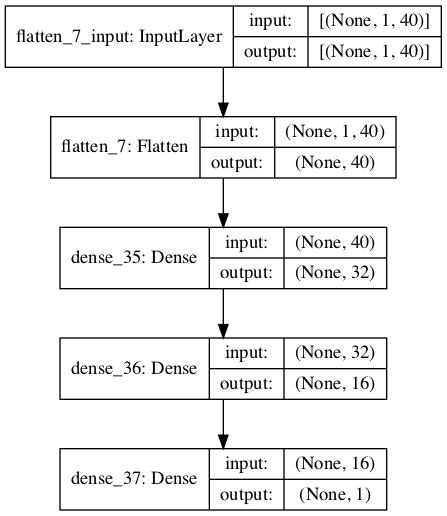

In [60]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='../data/model_plot.png', show_shapes=True, show_layer_names=True)

In [50]:
# specify loss function and optimizer (sgd)
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics=["accuracy"])

In [53]:
# make up some data
X_train = np.random.randint(0, 100, (500, 40))
Y_train = np.random.randint(0, 100, (500, 1))
X_valid = np.random.randint(0, 100, (200, 40))
Y_valid = np.random.randint(0, 100, (200, 1))


In [55]:
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20


2022-01-12 15:21:39.068960: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


2022-01-12 15:21:39.873324: W tensorflow/core/framework/op_kernel.cc:1692] OP_REQUIRES failed at sparse_xent_op.cc:114 : Invalid argument: Received a label value of 93 which is outside the valid range of [0, 1).  Label values: 82 82 54 72 64 88 87 36 77 92 54 38 51 20 46 27 14 0 7 10 83 0 30 93 34 79 17 41 71 17 17 20


InvalidArgumentError:  Received a label value of 93 which is outside the valid range of [0, 1).  Label values: 82 82 54 72 64 88 87 36 77 92 54 38 51 20 46 27 14 0 7 10 83 0 30 93 34 79 17 41 71 17 17 20
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at var/folders/qw/nxdjklks0lsd2yr222thlg8c0000gn/T/ipykernel_60697/3490617916.py:1) ]] [Op:__inference_train_function_1571]

Function call stack:
train_function
